# 토픽 모델링

- LDA
- BERTopic



# 0. 데이터 준비

In [1]:
import pandas as pd
import ast

df = pd.read_csv('./data/df_all_preprocessed_noun.csv', sep=',', quoting=1)
df['nouns'] = df['nouns'].apply(lambda x: ast.literal_eval(x))

이재명의 뉴스 데이터를 사용한 토픽 모델링을 진행해보자.   

In [2]:
df = df.loc[df['label'] == '이재명']

# 1. LDA

In [3]:
# 1. nouns 명사로 구성된 list of list 구성
nouns = df['nouns'].to_list()
len(nouns)

8033

In [4]:
# stopwords 제거
stopwords = ['이재명', '대표', 
            '때문', '기자', '무단', '배포', '금지']

nouns = [
   [noun for noun in noun_list if noun not in stopwords and len(noun) > 1] 
    for noun_list in nouns]
len(nouns)

8033

# GENSIM을 사용한 LDA 모델링

In [5]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [6]:
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint

# Dictionary 생성
dictionary = corpora.Dictionary(nouns)
dictionary.filter_extremes(no_below = 20) #20회 이하로 등장한 단어는 삭제


# Corpus 생성 (Bag-of-Words 형태)
corpus = [dictionary.doc2bow(text) for text in nouns]

# LDA 모델 학습
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,        # 원하는 토픽 수 설정
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [7]:
# 토픽 출력
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.050*"조사" + 0.025*"지지" + 0.024*"여론" + 0.019*"대선" + 0.017*"장관" + 0.016*"시장" '
  '+ 0.014*"결과" + 0.014*"응답" + 0.013*"포인트" + 0.013*"대결"'),
 (1,
  '0.017*"의원" + 0.013*"대선" + 0.013*"정치" + 0.013*"탄핵" + 0.012*"보수" + 0.008*"우리" '
  '+ 0.008*"생각" + 0.008*"윤석열" + 0.007*"사람" + 0.007*"중도"'),
 (2,
  '0.022*"재판" + 0.019*"선고" + 0.016*"출석" + 0.016*"사건" + 0.014*"증인" + '
  '0.013*"재판부" + 0.013*"검찰" + 0.012*"선거법" + 0.012*"혐의" + 0.011*"법원"'),
 (3,
  '0.023*"탄핵" + 0.021*"대행" + 0.017*"헌법" + 0.016*"권한" + 0.014*"의원" + 0.012*"서울" '
  '+ 0.011*"윤석열" + 0.010*"내란" + 0.008*"임명" + 0.008*"원내"'),
 (4,
  '0.013*"경제" + 0.011*"정부" + 0.008*"기업" + 0.008*"시장" + 0.007*"회사" + 0.007*"정책" '
  '+ 0.007*"민생" + 0.007*"시간" + 0.007*"관련" + 0.007*"반도체"')]


# LDA 모델링 결과 시각화

In [8]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # 경고 무시

# Jupyter에서 pyLDAvis 사용 설정
pyLDAvis.enable_notebook()

# 시각화 준비 및 출력
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.024027  0.056173       1        1  35.536828
3      0.120240  0.048223       2        1  23.771374
4      0.111777  0.169988       3        1  18.167104
2      0.098974 -0.272163       4        1  14.445554
0     -0.355019 -0.002221       5        1   8.079141, topic_info=     Term          Freq         Total Category  logprob  loglift
107    조사   6717.000000   6717.000000  Default  30.0000  30.0000
179    지지   5689.000000   5689.000000  Default  29.0000  29.0000
35     대선  10169.000000  10169.000000  Default  28.0000  28.0000
449    대행   8388.000000   8388.000000  Default  27.0000  27.0000
431    재판   5258.000000   5258.000000  Default  26.0000  26.0000
..    ...           ...           ...      ...      ...      ...
92     이상   1022.996577   2100.634880   Topic5  -4.7817   1.7964
63     신뢰    908.863580   1560.600120   Topic5  -4.9000   1.9753
52     서울   1269.777607   7674.362014   Topic5  -4.5656   0.7168
407    중도   1041.996757   4677.376570   Topic5  -4.7633   1.0143
74   연합뉴스    922.761452   3807.327691   Topic5  -4.8848   1.0986

[388 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.002117    %포인트
0         5  0.997340    %포인트
1         4  0.998964      1심
3289      3  0.997112  SK하이닉스
540       1  0.409298      가능
...     ...       ...     ...
139       5  0.382090      후보
2023      1  0.007874     후보자
2023      2  0.901578     후보자
2023      4  0.089989     후보자
2023      5  0.000562     후보자

[837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1])

# 2. BERTopic

In [10]:
# 데이터 준비
news_list = df['text'].to_list()

In [11]:
pip install bertopic sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip install ipywidgets

In [13]:
from bertopic import BERTopic

# news_list는 뉴스 문장 리스트라고 가정
# 예: news_list = ["윤석열 대통령은...", "한국은행이 금리를...", ...]

# BERTopic 모델 생성
topic_model = BERTopic(language="multilingual")  # multilingual = 한국어 지원 (e.g. KoBERT 기반)

# 모델 학습 및 토픽 추출
topics, probs = topic_model.fit_transform(news_list)

In [14]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("jhgan/ko-sbert-nli")  # 한국어 문장 의미 임베딩 모델

topic_model = BERTopic(embedding_model=embedding_model, language="multilingual")
topics, probs = topic_model.fit_transform(news_list)

In [15]:
# 토픽 요약 확인 (상위 10개)
topic_info = topic_model.get_topic_info()

# 실제 토픽 수 (노이즈 토픽 -1 제외)
num_real_topics = len(topic_info[topic_info.Topic != -1])
print(f"실제 생성된 토픽 개수: {num_real_topics}")

print(topic_info.head(10))

실제 생성된 토픽 개수: 172
   Topic  Count                  Name  \
0     -1   2218     -1_있다_이재명_대통령_이라고   
1      0    360     0_포인트_나타났다_김문수_였다   
2      1    192       1_집회_관저_한남동_대통령   
3      2    181    2_추경_추경을_지역화폐_25만원   
4      3    162   3_브라우저_업그레이드_설치_인터뷰   
5      4    120    4_반도체_예외_52시간_노동시간   
6      5    111       5_보수_중도보수_중도_진보   
7      6    105     6_실장은_문재인_임종석_비명계   
8      7     86  7_okjebo_제보는_학습_연합뉴스   
9      8     81       8_성장_대표는_쥐만_탈이념   

                                      Representation  \
0     [있다, 이재명, 대통령, 이라고, 대표의, 윤석열, 있는, 대한, 탄핵, 대표가]   
1  [포인트, 나타났다, 김문수, 였다, 여론조사, 차기, 홍준표, 오세훈, 국민의힘,...   
2      [집회, 관저, 한남동, 대통령, 탄핵, 집회를, 윤석열, 오후, 반대, 용산구]   
3   [추경, 추경을, 지역화폐, 25만원, 예산, 민생, 규모의, 소비, 정부가, 예산을]   
4  [브라우저, 업그레이드, 설치, 인터뷰, 앵커멘트, 원할하지, 종료에, 플래시, 버...   
5  [반도체, 예외, 52시간, 노동시간, 적용, 반도체특별법, 주52시간, 산업, 예...   
6  [보수, 중도보수, 중도, 진보, 진보적, 정체성을, 민주당은, 민주당이, 우클릭,...   
7    [실장은, 문재인, 임종석, 비명계, 지사는, 김경수, 당내, 대선, 한다, 김부겸]   
8  [okjebo, 제보는, 학습, 연합뉴스,

In [16]:
# 특정 토픽의 대표 키워드 보기
print("\n[토픽 0의 키워드]")
print(topic_model.get_topic(0))

for i in range(num_real_topics):
    print(f"\n[토픽 {i}의 키워드]")
    print(' '.join(k for k, v in topic_model.get_topic(i)))


[토픽 0의 키워드]
[('포인트', 0.011314060943429191), ('나타났다', 0.010429279076965317), ('김문수', 0.010423215203254912), ('였다', 0.010353578409948962), ('여론조사', 0.010210667928131262), ('차기', 0.010080417846276992), ('홍준표', 0.010073523329257372), ('오세훈', 0.010005452623527235), ('국민의힘', 0.00929201195234469), ('한동훈', 0.008805386168022686)]

[토픽 0의 키워드]
포인트 나타났다 김문수 였다 여론조사 차기 홍준표 오세훈 국민의힘 한동훈

[토픽 1의 키워드]
집회 관저 한남동 대통령 탄핵 집회를 윤석열 오후 반대 용산구

[토픽 2의 키워드]
추경 추경을 지역화폐 25만원 예산 민생 규모의 소비 정부가 예산을

[토픽 3의 키워드]
브라우저 업그레이드 설치 인터뷰 앵커멘트 원할하지 종료에 플래시 버전에서는 플레이어

[토픽 4의 키워드]
반도체 예외 52시간 노동시간 적용 반도체특별법 주52시간 산업 예외를 노동

[토픽 5의 키워드]
보수 중도보수 중도 진보 진보적 정체성을 민주당은 민주당이 우클릭 라고

[토픽 6의 키워드]
실장은 문재인 임종석 비명계 지사는 김경수 당내 대선 한다 김부겸

[토픽 7의 키워드]
okjebo 제보는 학습 연합뉴스 구독중 구독 이전 yna 활용 전재

[토픽 8의 키워드]
성장 대표는 쥐만 탈이념 실용주의 잡으면 진영이 이념과 기업 검든

[토픽 9의 키워드]
상속세 공제 최고세율 상속세를 감세 배우자 송언석 상속 일괄 개편

[토픽 10의 키워드]
대장동 성남fc 뇌물 공판에 서초구 서울중앙지방법원에서 배임 출석하고 특정범죄가중처벌등에관한법률위반 의혹

[토픽 11의 키워드]
뉴스1 김근식 news1 박수현 coinlocker 서울 여의도 이철희 안은나 2025

[토픽 12의 키워드]
pr

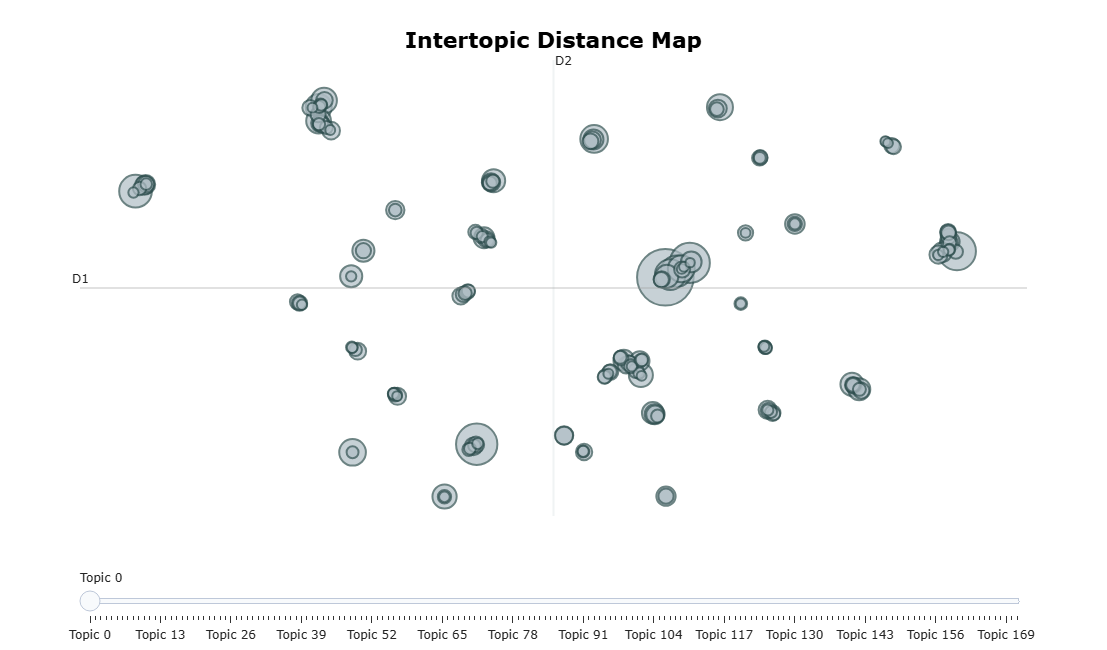

In [17]:
# 토픽 분포 시각화 (Jupyter에서 직접 보임)
topic_model.visualize_topics()

In [18]:
# 토픽 병합 (자동으로 비슷한 토픽 그룹화)
# target_topics: 최종적으로 몇 개의 토픽을 남길지
topic_model.reduce_topics(news_list, nr_topics=30)

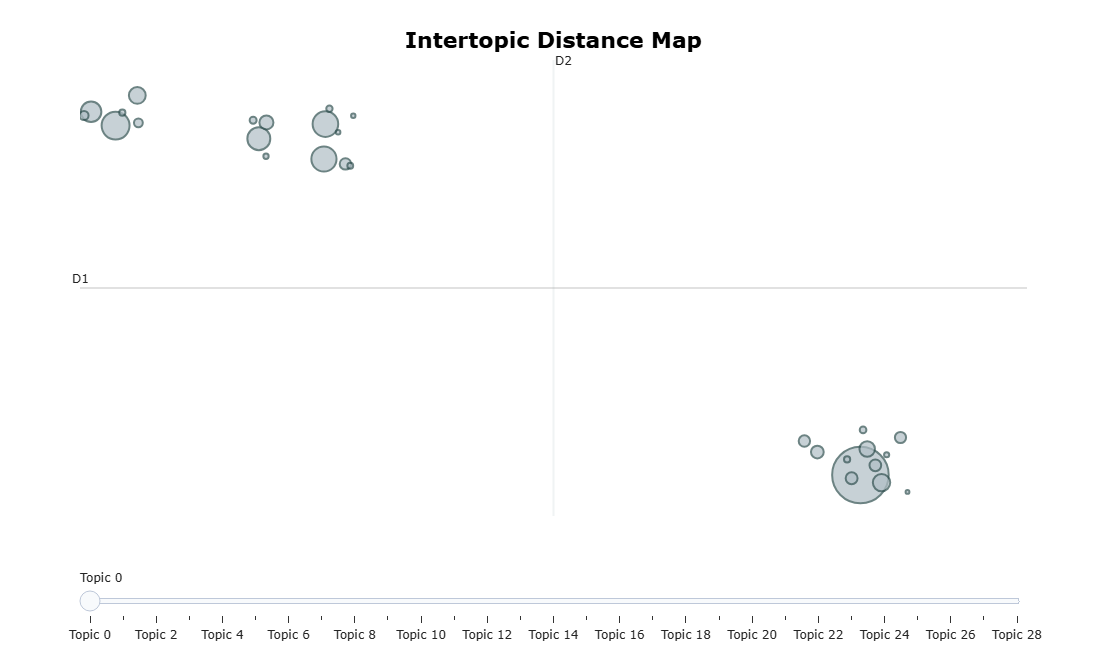

In [19]:

# 병합 후 시각화 다시 확인
topic_model.visualize_topics()

In [20]:
from collections import defaultdict

# 토픽별 뉴스 문장 모음
topic_docs = defaultdict(list)
for doc, topic in zip(news_list, topics):
    topic_docs[topic].append(doc)

# 각 토픽의 상위 3개 문장 출력
for topic_id, docs in sorted(topic_docs.items()):
    if topic_id == -1:
        continue  # -1은 outlier 토픽
    print(f"\n >> [Topic {topic_id}]")
    print("Top Words:", topic_model.get_topic(topic_id))
    for i, doc in enumerate(docs[:3]):
        print(f"  - {doc}")


 >> [Topic 0]
Top Words: [('이재명', 0.014738972530910539), ('있다', 0.013786345592512999), ('대표는', 0.01253132146548823), ('대표가', 0.011848187329675594), ('국민의힘', 0.010839100663122466), ('민주당', 0.0101278541298961), ('더불어민주당', 0.009692037074378868), ('한다', 0.009598299299254997), ('이라고', 0.009428023043691617), ('대표', 0.009134473982396385)]
  - 전체재생



●조사의뢰 : MBC

●조사기관 : (주)코리아리서치인터내셔널

●조사지역 : 전국

●조사기간 : 2024년 12월 29~30일(2일간)

●조사대상 : 전국 만 18세 이상

●조사방법 : 통신 3사 휴대전화 가상(안심)번호 전화면접

●피조사자 선정방법 : 성·연령·지역별 할당

●응답률 : 16.2% (6,188명 중 1,003명)

●가중치값 산출 및 적용방법 : 지역·성·연령별 가중치 부여(셀가중, 2024년 11월 말 행안부 인구통계 기준)

●표본오차 : 95% 신뢰 수준 ±3.1% 포인트

●질문내용 : 중앙선거여론조사심의위원회 홈페이지 참조



[2025년 신년 특집 정치·사회현안 여론조사 보고서]

https://image.imnews.imbc.com/pdf/politics/2025/01/20250101_2.pdf

[2025년 신년 특집 정치·사회현안 여론조사 통계표]

https://image.imnews.imbc.com/pdf/politics/2025/01/20250101_1.pdf

MBC가 신년을 맞아 실시한 차기 대통령 선거 후보 선호도 여론조사에서 이재명 더불어민주당 대표가 40%, 홍준표 대구시장이 8%, 한동훈 전 국민의힘 대표가 7%로 나타났습니다.그 뒤를 이어 오세훈 서울시장이 5%, 우원식 국회의장 4%, 